## 1. Imports

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import re
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from skimage.feature import hog
from FeatureExtractor import FeatureExtractor
from scipy.ndimage.measurements import label
%matplotlib inline

## 2. Helper Functions

In [82]:
# Function to define key for the sort function in order to sort naturally
def natural_key(string_):
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]

# Function to draw boxes on an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick) 
    # Return the image copy with boxes drawn
    return imcopy

# Function to draw labeled boxes on an image
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 8)
    # Return the image
    return img

# Function to add heatmap
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

# Function to apply a threshold to a heatmap
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

# Function to return HOG features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
    return features

# Function to compute color histogram features  
def color_hist(img, nbins=16):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the feature vector
    return hist_features

# Function for spatial binning, returns a feature vector
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features

# Function to split the dataset into training and validation folder
# used for timeseries data where random splitting will result in similar data in training and validation sets
def split_dataset(dataset, ylabel, split_pct=0.80):
    
    n_training_count = 0
    n_val_count = 0
    X_train = []
    X_val = []
    y_train = [] 
    y_val = []
    folders = []
    
    for file in dataset:
        folder = '/'.join(file.split('/')[:-1])
        folders.append(folder)
    
    # remove redundant folder names
    unique_folders = set(folders)
    #print(unique_folders)
    for folder in unique_folders:
        # loop on the files that are in the dataset and in the current folder
        files = [x for x in dataset if folder in x]
        # sort the files in the current folder naturally (ex: extra1, extra2 instead of extra1, extra11)
        sorted_files = sorted(files, key=natural_key)
        # Split into train and validation based on split percentage
        train_files = sorted_files[:int(len(sorted_files) * split_pct)]
        val_files = sorted_files[int(len(sorted_files) * split_pct):]
        # count the splitted files for sanity check
        n_training_count += len(train_files)
        n_val_count += len(val_files)

        # loop on the splitted files and load images
        imgs_train = [cv2.imread(img) for img in train_files]
        imgs_valid = [cv2.imread(img) for img in val_files]

        X_train.extend(imgs_train)
        X_val.extend(imgs_valid)
        
        # fill up y_train and y_val with the value of label passed as argument
        y_train.extend([ylabel for count in train_files])
        y_val.extend([ylabel for count in val_files])
        #print(y_train[:10])

    # sanity checks
    assert(n_training_count == len(X_train))
    assert(n_val_count == len(X_val))
    assert(len(X_train) == len(y_train))
    assert(len(X_val) == len(y_val))
    
    return X_train, y_train, X_val, y_val

# Function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        #  BGR should be the base color for this function as it is used for training the classifier !!!!
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


# Function to extract features from a single image window
def single_img_features(img, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'    
    # RGB can be the base color for this function as it is used for experimentation only !!!!
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

# Function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles=None):
    for idx, img in enumerate(imgs):
        plt.subplot(rows, cols, idx+1)
        plt.title(idx+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            if titles is not None:
                plt.title(titles[idx])
        else:
            plt.imshow(img)
            if titles is not None:
                plt.title(titles[idx])
                
    
# Function to draw labeled boxes on an image
def draw_labeled_bboxes_thresholded(img, labels):
      
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        x1 = np.min(nonzerox)
        y1 = np.min(nonzeroy)
        x2 = np.max(nonzerox)
        y2 = np.max(nonzeroy)
        
        # Reject outliers 
        width = x2 - x1
        height = y2 - y1
        
        alpha = 0.2
        
        if width > 64 and height > 64:
            # Define a bounding box based on min/max x and y
            bbox = ((x1, y1), (x2, y2))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 8)
    # Return the image
    return img

## 3. Data exploration

Number of vehicle samples found:8792
Number of non-vehicle samples found:8968
Image shape: 64x64x3 


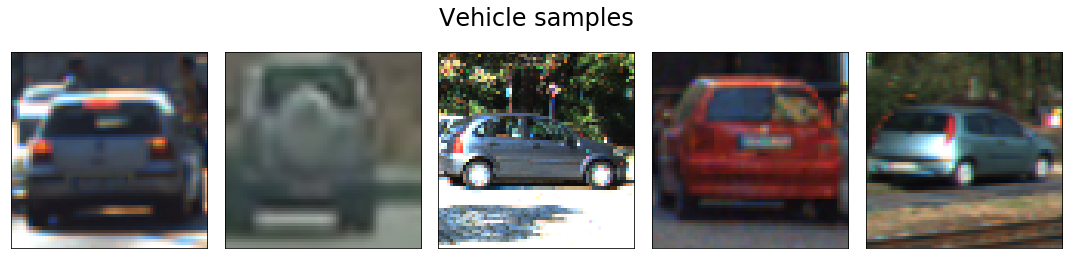

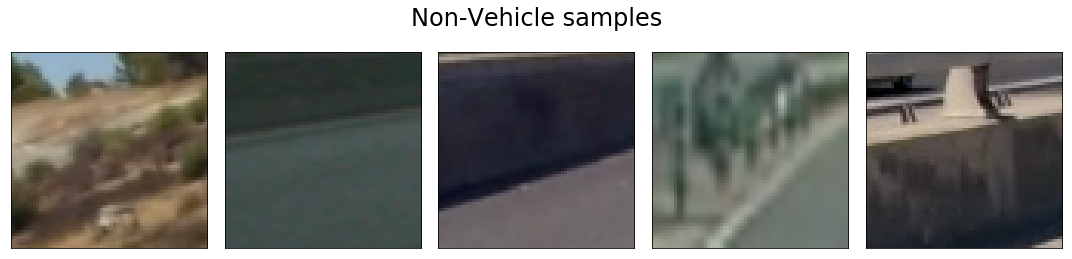

In [3]:
vehicle_loc='./labeled_data/vehicles/'
nonvehicle_loc='./labeled_data/non-vehicles/'  
vehicle_samples = glob.glob(vehicle_loc + '**/*.png', recursive=True)
nonvehicle_samples = glob.glob(nonvehicle_loc + '**/*.png', recursive=True)

print("Number of vehicle samples found:{}".format(len(vehicle_samples)))
print("Number of non-vehicle samples found:{}".format(len(nonvehicle_samples)))

sample_vehicle_image = mpimg.imread(vehicle_samples[np.random.randint(len(vehicle_samples))])
sample_non_vehicle_image = mpimg.imread(nonvehicle_samples[np.random.randint(len(nonvehicle_samples))])
img_shape = sample_vehicle_image.shape
print("Image shape: {}x{}x{} ".format(img_shape[0], img_shape[1], img_shape[2]) )


#Plotting random samples from each class
fig = plt.figure(figsize=(15,10))
for index in range(0, 5):
    plt.subplot(1, 5, index+1)
    sample_veh_img = mpimg.imread(vehicle_samples[np.random.randint(len(vehicle_samples))])
    plt.imshow(sample_veh_img)
    plt.xticks([])
    plt.yticks([])
fig.suptitle('Vehicle samples', y=0.7, fontsize=24)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(15,10))
for index in range(0, 5):
    plt.subplot(1, 5, index+1)
    sample_nonveh_img = mpimg.imread(nonvehicle_samples[np.random.randint(len(nonvehicle_samples))])
    plt.imshow(sample_nonveh_img)
    plt.xticks([])
    plt.yticks([])
fig.suptitle('Non-Vehicle samples', y=0.7, fontsize=24)
plt.tight_layout()
plt.show()

## 4. Hog Feature Parameters Experimentation

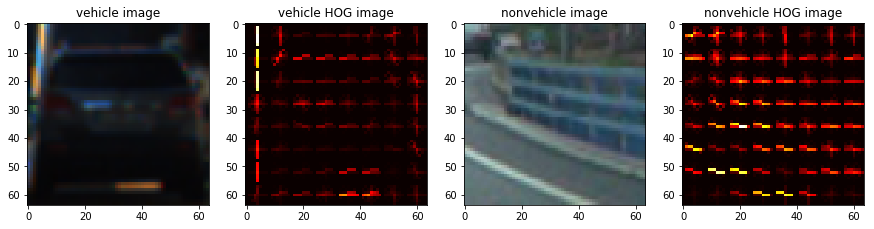

In [4]:
hog_feat = True # HOG features on or off
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins

vehicle_image = mpimg.imread(vehicle_samples[np.random.randint(len(vehicle_samples))])
non_vehicle_image = mpimg.imread(nonvehicle_samples[np.random.randint(len(nonvehicle_samples))])

            
veh_features, veh_hog_img = single_img_features(vehicle_image, color_space=color_space, 
                                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                                orient=orient, pix_per_cell=pix_per_cell, 
                                                cell_per_block=cell_per_block, 
                                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                                hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
nonveh_features, nonveh_hog_img = single_img_features(non_vehicle_image, color_space=color_space, 
                                                      spatial_size=spatial_size, hist_bins=hist_bins, 
                                                      orient=orient, pix_per_cell=pix_per_cell, 
                                                      cell_per_block=cell_per_block, 
                                                      hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                                      hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

images = [vehicle_image, veh_hog_img, non_vehicle_image, nonveh_hog_img]
titles = ['vehicle image', 'vehicle HOG image', 'nonvehicle image', 'nonvehicle HOG image']
fig = plt.figure(figsize=(15,10))
visualize(fig, 1, 4, images, titles)




## 5. Loading the dataset

In [5]:
X_train_samples = []
y_train_samples = []
X_val_samples = []
y_val_samples = []

# Training / validation split percentage
split_pct = 0.75

# iterate on the two datasets to load data
# index will be 0 while iterating on nonvehicle_samples and 1 while iterating on vehicle_samples
# index will be passed to split_dataset() as the ylabel parameter
for index, dataset in enumerate([nonvehicle_samples, vehicle_samples]):
    X_train_dataset, y_train_dataset, X_val_dataset, y_val_dataset = split_dataset(dataset, index, split_pct)
    X_train_samples.extend(X_train_dataset)
    y_train_samples.extend(y_train_dataset)
    X_val_samples.extend(X_val_dataset)
    y_val_samples.extend(y_val_dataset)

X_train = np.array(X_train_samples)
y_train = np.array(y_train_samples)
X_val = np.array(X_val_samples)
y_val = np.array(y_val_samples)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(13318, 64, 64, 3)
(13318,)
(4442, 64, 64, 3)
(4442,)


## 6. Data shuffling and features extraction

In [6]:
# shuffle the data
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=0)
x_val_shuffled, y_val_shuffled = shuffle(X_val, y_val, random_state=0)


# Extracting features
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins


hog_feat = True # HOG features on or off
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off


t=time.time()
X_train_features = np.array(extract_features(X_train_shuffled, color_space=color_space, spatial_size=spatial_size,
                                             hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                             cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                             spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat))


X_val_features = np.array(extract_features(x_val_shuffled, color_space=color_space, spatial_size=spatial_size,
                                             hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                             cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                             spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat))

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

print(X_train_features.shape)
print(X_val_features.shape)

72.44 Seconds to extract features...
(13318, 9048)
(4442, 9048)


## 7. Normalization and training the classifier

In [7]:
# Normalizing features
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_features)
X_test_normalized = scaler.transform(X_val_features)

print('Feature vector length:', len(X_train_normalized[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train_normalized, y_train_shuffled)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test_normalized, y_val_shuffled), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test_normalized[0:n_predict]))
print('For these',n_predict, 'labels: ', y_val_shuffled[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


Feature vector length: 9048
3.14 Seconds to train SVC...
Test Accuracy of SVC =  0.9883
My SVC predicts:  [0 1 1 1 1 0 1 1 0 0]
For these 10 labels:  [0 1 1 1 1 0 1 1 0 0]
0.00209 Seconds to predict 10 labels with SVC


## 8. Search and Classify

In [95]:
def convert_color(img, conv='BGR2YCrCb'):
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)


# function to apply sliding windows, extract features and make predictions on each window
def detect_vehicles(img, ystart, ystop, scale, svc, X_scaler, orient=10, pix_per_cell=8,
                  cell_per_block=2, spatial_size=(32,32), hist_bins=32, color_conv='BGR2YCrCb'):
    
    draw_img = np.copy(img)  
    # extract the portion of the image to search
    img_tosearch = img[ystart:ystop,:,:]
    
    #ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2HLS)
    ctrans_tosearch = convert_color(img_tosearch, conv = color_conv)
    
    # resizing the image applies the same effect as resizing the window
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # defines overlap distance was 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    veh_boxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))      
            test_prediction = svc.predict(test_features)
            
            # decision function is used to get confidence score of each prediction
            probability = svc.decision_function(test_features)
                      
            if test_prediction == 1:
            # return windows only when the prediction confidence is above a threshold
                if probability > 0.4:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    veh_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                    
                
    return veh_boxes

## 9. Testing the classifier

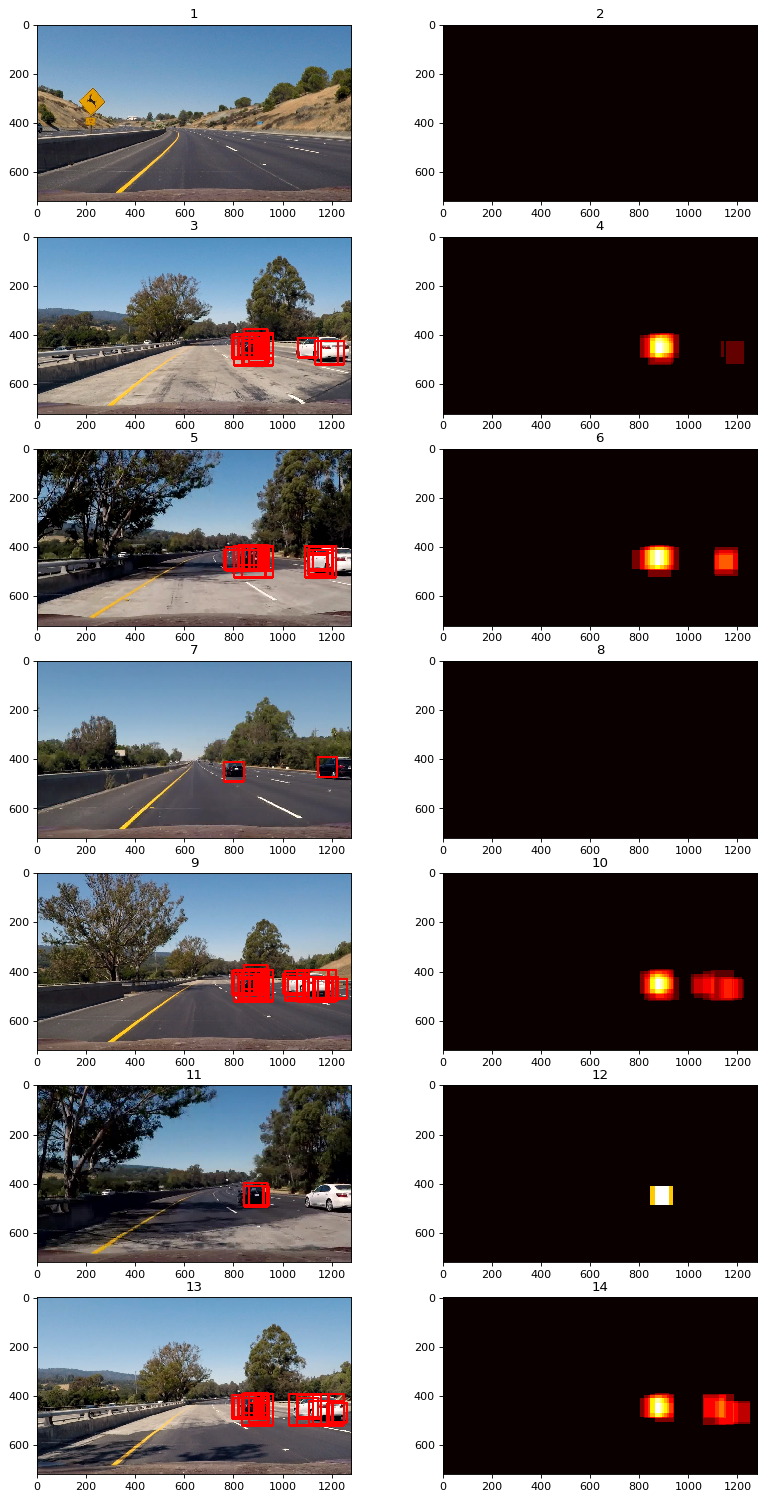

In [104]:
test_images = glob.glob('./test_images' + '/test**.jpg')

y_start = np.array([350, 350, 394, 458])
y_stop =  np.array([670, 638, 650, 650])   

#scales equivalent to window sizes 80 x 80, 96 x 96, 128 x 128 and 194 x 194 respectively
scales = np.array([1.25, 1.5, 2, 3])

processed_images = []
thresholded_images = []

for img in test_images:
    image = cv2.imread(img)
    
    draw_img = np.copy(image)
    rgb_draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)    
    heat = np.zeros_like(rgb_draw_img[:,:,0]).astype(np.float)
    
    img_boxes = []
    #for scale in scales:
    for ystart,ystop,scale in zip(y_start,y_stop,scales):
        scale_boxes  = detect_vehicles(image, ystart, ystop, scale, svc, scaler, orient=10, pix_per_cell=8,
                                  cell_per_block=2, spatial_size=(32,32), hist_bins=32, color_conv='BGR2YCrCb')
        #print(scale_boxes)
        img_boxes.extend(scale_boxes)

    # Add heat to each window in window list
    heatmaps = add_heat(heat,img_boxes)
    
    # draw boxes around detected vehicles
    out_img = draw_boxes(rgb_draw_img, img_boxes, color=(255, 0, 0), thick=8) 
    
    
    # Apply threshold to help remove false positives
    heatmaps_sum = apply_threshold(heatmaps, 2)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmaps)

    # draw labeled boxes
    out_img_heatmap = draw_labeled_bboxes(rgb_draw_img, labels)
    
    processed_images.append(out_img)
    processed_images.append(heatmaps)

    thresholded_images.append(out_img_heatmap)
    
fig = plt.figure(figsize=(12,24), dpi=80)
visualize(fig, 7, 2, processed_images)

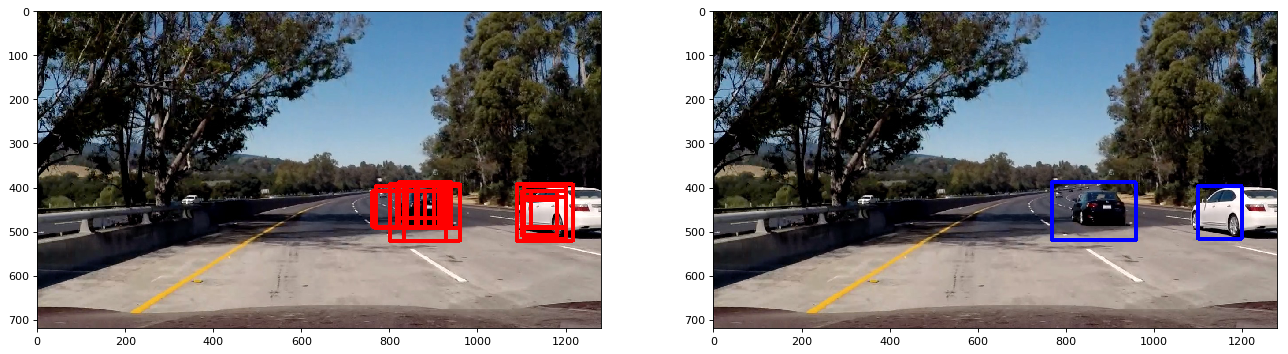

In [126]:
plt.figure(figsize=(20,20), dpi=80)
plt.subplot(1,2,1)
plt.imshow(processed_images[4])

plt.subplot(1,2,2)
plt.imshow(thresholded_images[2])
plt.show()

## 10. Video Pipeline

In [97]:
def processframe(frame):  ## !!! BASE COLOR MAP SHOULD BE RGB !!!!!!!!!
    
    
    global heatmaps_list    # list of heatmaps over last N frames
    global heatmaps_sum     # global variable to sum heatmaps over last N frames
    
    orient = 10              # number of orientation bins
    pix_per_cell = 8         # cell size over which each gradient histogram is computed
    cell_per_block = 2       # local area over which the histogram counts in a given cell will be normalized
    spatial_size = (32, 32)  # Spatial binning dimensions
    hist_bins = 32           # Number of histogram bins
    
    y_start = np.array([350, 350, 394, 458])   # Min y-coordinates to search in slide_window()
    y_stop =  np.array([590, 638, 650, 650])   # Max y-coordinates to search in slide_window()
    
    scales = np.array([1.25, 1.5, 2, 3])   # Search window scale

    image = np.copy(frame)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    img_boxes = []

    # apply sliding window with multiple scales
    for ystart,ystop,scale in zip(y_start,y_stop,scales):
        scale_boxes  = detect_vehicles(image, ystart, ystop, scale, svc, scaler, orient=10, pix_per_cell=8,
                                  cell_per_block=2, spatial_size=(32,32), hist_bins=32, color_conv='RGB2YCrCb')
        img_boxes.extend(scale_boxes)
    
    # Add heat to each window in window list
    heat = add_heat(heat,img_boxes)
  
    # Sum the heatmaps from each frame
    heatmaps_sum = heatmaps_sum + heat
    
    # Create a list of heatmaps over the last N frames
    heatmaps_list.append(heat)
    
    # when N frames is reached, subtract old heat map to keep running sum of last n heatmaps
    if len(heatmaps_list) > 40: #20
        first_heatmap = heatmaps_list.pop(0)
        heatmaps_sum -= first_heatmap
        # protect against going negative
        heatmaps_sum = np.clip(heatmaps_sum,0.0,1000000.0)
        
    # Apply threshold to help remove false positives
    heatmaps_sum = apply_threshold(heatmaps_sum, 3) #2
                   
    # Find final boxes from heatmap using label function
    labels = label(heatmaps_sum)

    # draw labeled boxes
    draw_img = draw_labeled_bboxes_thresholded(np.copy(frame), labels) 
    #draw_img = draw_boxes(np.copy(frame), img_boxes, color=(0, 0, 255), thick=6)                   
    return draw_img

In [ ]:
heatmaps_list = []
heatmaps_sum = np.zeros((720,1280)).astype(np.float64)


from moviepy.editor import VideoFileClip
white_output = 'project_video_processed.mp4'
clip1 = VideoFileClip("project_video.mp4") 
white_clip = clip1.fl_image(processframe)

%time white_clip.write_videofile(white_output, audio=False)